In [3]:
import datetime

import numpy as np
import pandas as pd

from scipy.io import mmread

import matplotlib.pyplot as plt

In [1]:
import os
os.__file__

'/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/os.py'

# load data

## expression data

In [4]:
exp_data=mmread('data/HumanLiver_extract/HumanLiver.data.counts.mm').toarray().astype(float)
with open('data/HumanLiver_extract/HumanLiver.data.col','r') as f: exp_data_col=[i.strip().strip('"') for i in f.read().split()]
with open('data/HumanLiver_extract/HumanLiver.data.row','r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]
assert exp_data.shape==(len(exp_data_row),len(exp_data_col))

In [5]:
assert len(set(exp_data_row))==len(exp_data_row)
assert len(set(exp_data_col))==len(exp_data_col)

In [6]:
exp_data,exp_data.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), (20007, 8444))

In [7]:
exp_data_row[:5],exp_data_col[:5]

(['RP11-34P13.7', 'FO538757.2', 'AP006222.2', 'RP4-669L17.10', 'RP5-857K21.4'],
 ['P1TLH_AAACCTGAGCAGCCTC_1',
  'P1TLH_AAACCTGTCCTCATTA_1',
  'P1TLH_AAACCTGTCTAAGCCA_1',
  'P1TLH_AAACGGGAGTAGGCCA_1',
  'P1TLH_AAACGGGGTTCGGGCT_1'])

## cluster info 

In [8]:
exp_data_meta=pd.read_csv('data/HumanLiver_extract/HumanLiver.metadata.tsv',sep='\t')
exp_data_meta.head()

,total_counts,total_features,orig.ident,res.0.8,S.Score,G2M.Score,Phase
P1TLH_AAACCTGAGCAGCCTC_1,2943,1427,P1TLH,12,0.046089,0.000349,S
P1TLH_AAACCTGTCCTCATTA_1,10897,2522,P1TLH,17,-0.000357,0.009434,G2M
P1TLH_AAACCTGTCTAAGCCA_1,1914,1018,P1TLH,12,0.012811,-0.056561,S
P1TLH_AAACGGGAGTAGGCCA_1,5574,1798,P1TLH,10,-0.011324,-0.047102,G1
P1TLH_AAACGGGGTTCGGGCT_1,3700,1417,P1TLH,2,0.057467,-0.003861,S


`clusterid_to_clustername` is used to convert integers in `res.0.8` to cell-type name

In [9]:
clusterid_to_clustername=pd.read_csv('data/HumanLiver_extract/HumanLiver.clusterid_to_clustername.tsv',sep='\t',header=None,index_col=0)
clusterid_to_clustername[1]=clusterid_to_clustername[1].str.replace(' ','_')
len(clusterid_to_clustername[1].unique()),

(11,)

# Panglao

In [446]:
markers_db=pd.read_csv("data/PanglaoDB_markers_27_Mar_2020.tsv.gz",sep='\t')
markers_db=markers_db[markers_db['species'].str.contains('Hs')].drop(columns='species')
markers_db.head()

,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse
0,CTRB1,Acinar cells,CTRB,0.017,chymotrypsinogen B1,protein-coding gene,1.0,Endoderm,Pancreas,1.000000,0.957143,0.000629,0.015920
1,KLK1,Acinar cells,Klk6,0.013,kallikrein 1,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.314286,0.005031,0.012826
2,RBPJL,Acinar cells,RBP-L|SUHL|RBPSUHL,0.001,recombination signal binding protein for immun...,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.000000,0.000000,0.000000
3,PTF1A,Acinar cells,PTF1-p48|bHLHa29,0.001,pancreas associated transcription factor 1a,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.157143,0.000629,0.000773
5,CELA3A,Acinar cells,ELA3|ELA3A,0.001,chymotrypsin like elastase family member 3A,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.128571,0.000000,0.000000


In [461]:
#markers_db[(markers_db['official gene symbol']=='FXDY2') |(markers_db['nicknames'].str.contains('FXDY2'))],'FXDY2' in exp_data_row

## Marker info

In [462]:
"""
# New one
clustername_to_markers={'Cholangiocytes':['KRT19','EPCAM','FXYD2','CLDN4','CLDN10','SOX9','MMP7','CXCL1','CFTR','TFF2','KRT7','CD24'],
'Mature_B_cells':['MS4A1','IGHD','CD79A','PTPRC','IGKC','CD19'],
'Hepatocytes':['ALB','HAMP','ARG1','PCK1','AFP','BCHE'],
'LSECs':['CALCRL','VWF','PECAM1','CLEC14A','EMCN'],
'Hepatic_Stellate_Cells':['ACTA2','COL1A1','TAGLN','COL1A2','COL3A1','SPARC','RBP1','DCN','MYL9'],
'Macrophages':['CD68','MARCO','FCGR3A','LYZ','PTPRC','AIF1'],
'ab_T_cells':['CD2','CD3D','TRAC','IL32','CD3E','PTPRC'],
'gd_T_cells':['NKG7','FCGR3A','HOPX','GNLY','CMC1','KLRF1','CCL3','PTPRC'],
'NK_cells':['GZMK','KLRF1','CCL3','CMC1','NKG7','PTPRC'],
'Plasma_cells':['CD27','IGHG1','IGHA1','IGHM','CD79A','PTPRC','IGKC'],
'Erythroid_cells':['HBB','SLC25A37','CA1','ALAS2'],
'other':[]                           
}
"""


# Old one
clustername_to_markers={'Hepatocytes':['ALB','HAMP','ARG1','PCK1','AFP','BCHE'],
'LSECs':['CALCRL','FCGR2B','VWF'],
'Cholangiocytes':['KRT19','EPCAM','FXYD2','CLDN4','CLDN10','SOX9','MMP7','CXCL1','CFTR','TFF2','KRT7','CD24'],
'Hepatic_Stellate_Cells':['ACTA2','COL1A1','TAGLN','COL1A2','COL3A1','SPARC','RBP1','DCN','MYL9'],
'Macrophages':['CD68','MARCO'],
'ab_T_cells':['CD2','CD3D','TRAC','IL32','CD3E'],
'gd_T_cells':['NKG7','FCGR3A','HOPX','GNLY'],
'NK_cells':['GZMK','KLRF1','CCL3','CMC1'],
'Plasma_cells':['CD27','IGHG1'],
'Mature_B_cells':['MS4A1','LTB','CD52','IGHD'],
'Erythroid_cells':['HBB','SLC25A37','CA1','ALAS2'],
'other':[]    
}


#for key,value in clustername2markers_new.items():
#    for i in value:
#        print(markers_db[(markers_db['official gene symbol']==i)].shape)
#markers_db[(markers_db['official gene symbol']=='CD32B') |(markers_db['nicknames'].str.contains('CD32B'))]
#clustername_to_markers

In [463]:
clustername_unique=list(clustername_to_markers.keys())
exp_data_meta_clusterid_clusteridunique=clusterid_to_clustername.loc[exp_data_meta['res.0.8'].values][1].apply(lambda x: clustername_unique.index(x))

In [464]:
marker_unique=np.unique([j for i in list(clustername_to_markers.values()) for j in i])
marker_unique_exp_data_idx=[exp_data_row.index(marker) for marker in marker_unique]
marker_unique

array(['ACTA2', 'AFP', 'ALAS2', 'ALB', 'ARG1', 'BCHE', 'CA1', 'CALCRL',
       'CCL3', 'CD2', 'CD24', 'CD27', 'CD3D', 'CD3E', 'CD52', 'CD68',
       'CFTR', 'CLDN10', 'CLDN4', 'CMC1', 'COL1A1', 'COL1A2', 'COL3A1',
       'CXCL1', 'DCN', 'EPCAM', 'FCGR2B', 'FCGR3A', 'FXYD2', 'GNLY',
       'GZMK', 'HAMP', 'HBB', 'HOPX', 'IGHD', 'IGHG1', 'IL32', 'KLRF1',
       'KRT19', 'KRT7', 'LTB', 'MARCO', 'MMP7', 'MS4A1', 'MYL9', 'NKG7',
       'PCK1', 'RBP1', 'SLC25A37', 'SOX9', 'SPARC', 'TAGLN', 'TFF2',
       'TRAC', 'VWF'], dtype='<U8')

In [465]:
pi_true=np.array([np.sum(exp_data_meta_clusterid_clusteridunique==i) for i in sorted(np.unique(exp_data_meta_clusterid_clusteridunique))])/exp_data_meta_clusterid_clusteridunique.shape[0]
M_true=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,exp_data_meta_clusterid_clusteridunique==i],axis=1) for i in sorted(np.unique(exp_data_meta_clusterid_clusteridunique))])

In [466]:
cell_size_factor=pd.read_csv('data/analysis/size_factor_cluster.tsv',sep='\t',header=None)[0].values.astype(float)#.reshape(-1,1)
cell_size_factor

array([1.0309219 , 2.38041632, 0.72895119, ..., 1.45360587, 0.51372201,
       0.40260243])

In [484]:
Y=exp_data[marker_unique_exp_data_idx].transpose().astype(float)
Y.shape

(8444, 55)

In [468]:
marker_onehot=np.array([np.sum(np.eye(len(marker_unique))[[marker_unique.tolist().index(marker) for marker in value]],axis=0) for key,value in clustername_to_markers.items()])
marker_onehot.shape
#marker_onehot.T

(12, 55)

In [469]:
exp_data_col_patient=pd.Series(exp_data_col).str.slice(start=1,stop=2).astype(int).values
x_data_covariate=np.eye(len(np.unique(exp_data_col_patient)))[exp_data_col_patient-1]
x_data_intercept=np.array([np.ones(Y.shape[0])]).transpose()
x_data_null=np.concatenate([x_data_intercept,x_data_covariate[:,:]],axis=1)
x_data_null.shape

(8444, 6)

# Torch porting

In [471]:
# Asuume that the following variables are initialized

# Input
Y
s=cell_size_factor
X=x_data_null.copy()[:,[0, 1,2,3,4]]
X=x_data_null.copy()[:,[0, 1,2]]
# 234 x
# 34 x
# 123 x
rho=marker_onehot

delta_min=2
B=10
LR=1e-1

# Optional
EM_ITER_MAX=20
M_ITER_MAX=10000

BATCH_SIZE=Y.shape[0]
NUM_WORKERS=0

LOWER_BOUND=1e-10
THETA_LOWER_BOUND=1e-20


Q_diff_tolerance=1e-4
LL_diff_tolerance=1e-4
X.shape

(8444, 3)

In [473]:
import math
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [474]:
torch.set_default_dtype(torch.float64) 

In [475]:
device_cpu=torch.device("cpu")
device_cuda_list=[torch.device("cuda:{}".format(i)) for i in range(6)][::-1]

In [476]:
#from basic_tools import Cell_Dataset,Masked
class Masked_Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, mask):
        #print('aaaa')
        output=input
        ctx.save_for_backward(input, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, mask = ctx.saved_tensors
        grad_input = grad_mask = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mul(mask)

        return grad_input, grad_mask
    
class Masked(nn.Module):    
    def __init__(self, mask):    
        super(Masked, self).__init__()
        
        self.mask = nn.Parameter(torch.Tensor(mask)==1, requires_grad=False)    
        
        
    def forward(self, input):
        return Masked_Function.apply(input, self.mask)

    def extra_repr(self):
        return 'mask={}'.format(self.mask.shape)  

In [477]:
import math
class NB_logprob(nn.Module):
    def __init__(self):
        super(NB_logprob,self).__init__()
        
    def forward(self,total_count,probs,value):
        
        #eps = torch.finfo(probs.dtype).eps
        #probs_clamped=probs.clamp(min=eps, max=1 - eps)        
        probs_clamped=probs
        logits=torch.log(probs_clamped) - torch.log1p(-probs_clamped)
        #logits=torch.log(probs_clamped)
        
        log_unnormalized_prob = (total_count * F.logsigmoid(-logits) +
                                 value * F.logsigmoid(logits))
        log_normalization = (-torch.lgamma(total_count + value) + torch.lgamma(1. + value) +
                             torch.lgamma(total_count))

        return log_unnormalized_prob - log_normalization
    
class Normal_logprob(nn.Module):
    def __init__(self):
        super(Normal_logprob,self).__init__()
        
    def forward(self,loc,scale,value):
    
        var = (scale ** 2)
        log_scale = torch.log(scale)
        
        
        #print(loc.shape,scale.shape,value.shape)
        return -((value - loc) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))    
        #return log_scale
        
class Poisson_logprob(nn.Module):
    def __init__(self):
        super(Poisson_logprob,self).__init__()
        
    def forward(self,rate,value):
        #rate=rate.clamp(min=1e-3)+(-1)/rate.clamp(max=-1e-5)
        
        return (rate.log() * value) - rate - (value + 1).lgamma()
    
class Dirichlet_logprob(nn.Module):
    def __init__(self):
        super(Dirichlet_logprob,self).__init__()
        
    def forward(self,concentration,value):
        
        return ((torch.log(value) * (concentration - 1.0)).sum(-1) +
                torch.lgamma(concentration.sum(-1)) -
                torch.lgamma(concentration).sum(-1))
    
        
NB_logprob=NB_logprob()        
normal_logprob=Normal_logprob()
poisson_logprob=Poisson_logprob()
dirichlet_logprob=Dirichlet_logprob()

In [479]:
class Cell_Dataset(Dataset):
    def __init__(self,Y,X,s):
        self.Y=Y
        self.X=X
        self.s=s
        
    def __len__(self):
        return self.Y.shape[0]
    
    def __getitem__(self,idx):
        item= {"Y":self.Y[idx,:],"X":self.X[idx,:],"s":self.s[idx]}
        return item  

In [481]:
def run_EM():
    global gamma_new,Q_new,LL_new
    
    print('Start time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    with torch.no_grad():
        for batch_idx,batch in enumerate(cell_dataloader):
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)    
        gamma_fixed,_,LL_old=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
        _,Q_old,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_fixed,mode='M')

    print(LL_old)
    print(Q_old)

    for em_idx in range(EM_ITER_MAX):#
        #optimizer = optim.Adam(model.parameters(),lr=0.1,eps=1e-3,betas=(0.9,0.999))
        LL_new=torch.zeros_like(LL_old)
        #optimizer = optim.Adam(model.parameters(),lr=LR)
        for batch_idx,batch in enumerate(cell_dataloader):
            # It is usually just one iteration(batch).
            # However, developer of cellAssign may have done this for extreme situation of larse sample size
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)

            #############
            #E-step
            ######### ####
            with torch.no_grad():
                gamma_new,_,_=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='E')

            #############
            #M-step
            #############
            for m_idx in range(M_ITER_MAX):#
            #for m_idx in range(20):#    
                optimizer.zero_grad()
                _,Q_new,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_new,mode='M')
                Q_new.backward()
                optimizer.step()
                
                #Constraint
                model.delta_log.data=model.delta_log.data.clamp(min=model.delta_log_min)
                model.NB_basis_a.data=model.NB_basis_a.data.clamp(min=0)

                if m_idx%20==0:
                    #print(sorted(model.delta_log.cpu().detach().numpy().flatten())[-10:])
                    Q_diff=(Q_old-Q_new)/torch.abs(Q_old)
                    Q_old=Q_new
                    print('M: {}, Q: {} Q_diff: {}'.format(m_idx,Q_new,Q_diff))    
                    if m_idx>0 and torch.abs(Q_diff)<Q_diff_tolerance:
                        print('M break')
                        break                
            #############
            #Look at LL
            #############
            with torch.no_grad():
                _,_,LL_temp=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
                LL_new+=LL_temp

        LL_diff=(LL_new-LL_old)/torch.abs(LL_old)
        LL_old=LL_new
        print('EM: {}, LL: {} LL_diff: {}'.format(em_idx,LL_new,LL_diff))
        if LL_diff<LL_diff_tolerance:
            print('EM break')
            break
    print('End time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))    
    return gamma_new,Q_new,LL_new

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions.negative_binomial import NegativeBinomial
from torch.distributions.normal import Normal
from torch.distributions.dirichlet import Dirichlet

class Custom_Model(nn.Module):
    def __init__(self,Y,rho,X_col=5,delta_min=2,LOWER_BOUND=1e-10,THETA_LOWER_BOUND=1e-20):
        # Y,rho are needed for model parameter initialization
        super(Custom_Model, self).__init__()
        
        #rho
        self.masked=Masked(rho)
         
        #delta
        self.delta_log_min=np.log(delta_min) #
        self.delta_log=nn.Parameter(torch.Tensor(np.random.uniform(-2,2,size=rho.shape)),requires_grad=True) # (C,G)
        self.delta_log.data=self.delta_log.data.clamp(min=self.delta_log_min)

        #delta prior
        self.delta_log_mean=nn.Parameter(0*torch.ones(1),requires_grad=True)        
        self.delta_log_variance=nn.Parameter(1*torch.ones(1),requires_grad=True)           
        
        #beta
        Y_colmean=np.mean(Y,axis=0)
        beta_init=np.hstack([((Y_colmean-Y_colmean.mean())/np.std(Y_colmean)).reshape(-1,1),\
                     np.zeros((Y.shape[1],X_col-1))]).T
        self.beta=nn.Parameter(torch.Tensor(beta_init),requires_grad=True) # (P,G)
        
        #print(((np.mean(Y,axis=0)-np.mean(Y))/np.std(np.mean(Y,axis=0))).reshape(-1,1))
        #print(self.beta)
        
        #NB parameters
        self.NB_basis_mean=nn.Parameter(torch.Tensor(np.linspace(np.min(Y),np.max(Y),B)), requires_grad=False)
        self.NB_basis_a=nn.Parameter(torch.ones(B),requires_grad=True) # not consistent with paper.. hmm. strange...
        self.NB_basis_b=nn.Parameter((1/(2*((np.max(Y)-np.min(Y))/(B-1))**2))*torch.ones(B),requires_grad=False) # hmm... strange
        
        #theta
        self.theta_logit=nn.Parameter(torch.Tensor(np.random.normal(loc=0.,scale=1.,size=rho.shape[0])),requires_grad=True)
        
        # lower bounds
        self.LOWER_BOUND=LOWER_BOUND
        self.THETA_LOWER_BOUND=THETA_LOWER_BOUND
        
    def forward(self,Y,X,s,gamma_fixed=None,mode='E'):
        delta_log_masked=self.masked(self.delta_log) #(C,G)
        delta=torch.exp(delta_log_masked)*self.masked.mask
        
        X_beta_s=X.matmul(self.beta)+torch.log(s.view(-1, 1)) #(N,P)*(P,G) + (N,1) = (N,G)
        
        mu_log=X_beta_s.unsqueeze(dim=1).repeat(1,delta.shape[0],1)+delta #(N,1,G)+(C,G) = (N,C,G)
        
        mu=torch.exp(mu_log) # (N,C,G)
        
        #Y_extend=Y.view(Y.shape[0],1,Y.shape[1]).repeat(1,mu_log.shape[1],1) # (N,C,G)
        Y_extend=Y.unsqueeze(dim=1).repeat(1,mu_log.shape[1],1)
        
        # Negative Binomial
        phi_B=self.NB_basis_a*torch.exp(-self.NB_basis_b*(mu_log.unsqueeze(dim=3).repeat(1,1,1,B)-self.NB_basis_mean)**2) # (N,C,G,B)
        phi=torch.sum(phi_B,axis=3)+self.LOWER_BOUND
        Y_logprob=NB_logprob(total_count=phi,probs=(mu/(mu+phi)),value=Y_extend) # (N,C,G)
        
        # Normal
        #Y_logprob=normal_logprob(loc=mu_log,scale=torch.ones(1).to(device),value=Y_extend) # (N,C,G)
        
        # Poisson
        #Y_logprob=poisson_logprob(rate=mu,value=Y_extend) # (N,C,G)

        theta_log=F.log_softmax(self.theta_logit,dim=0) # (C)          
        Y_logprob_reduce=torch.sum(Y_logprob,axis=2)+theta_log # (N,C)
        
        Y_logprob_reduce_reduce=torch.logsumexp(Y_logprob_reduce,dim=1).view(-1,1) # (N,1)
        
        gamma=torch.exp(Y_logprob_reduce-Y_logprob_reduce_reduce) # (N,C)

        if mode=='E':
            return gamma,None,None
        elif mode=='M' or mode=='LL':
            theta_log_prob=dirichlet_logprob(concentration=1e-2*torch.ones_like(theta_log),value=(torch.exp(theta_log)+self.THETA_LOWER_BOUND))
            #print(1e-2*torch.ones_like(theta_log))
            delta_log_prob=torch.sum(normal_logprob(loc=self.delta_log_mean*self.masked.mask,scale=self.delta_log_variance,value=delta_log_masked))            
            if mode=='M':
                Q=-torch.sum(gamma_fixed*Y_logprob_reduce) # (N,C) (N,C)
                Q=Q-theta_log_prob
                Q=Q-delta_log_prob
                return gamma,Q,None
            elif mode=='LL':      
                LL=torch.sum(Y_logprob_reduce_reduce) # product of likelihood(y_i)-> (1) 
                print(LL,theta_log_prob,delta_log_prob)
                LL=LL+theta_log_prob
                LL=LL+delta_log_prob
                return gamma,None,LL
        else:
            raise          

In [487]:
cell_dataset=Cell_Dataset(Y,X,s)
cell_dataloader=DataLoader(dataset=cell_dataset,shuffle=False,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS)

In [488]:
device=device_cuda_list[0]#
model=Custom_Model(Y,rho,X_col=X.shape[1],delta_min=delta_min,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)
optimizer = optim.Adam(model.parameters(),lr=LR)#,betas=(0.92, 0.999))

In [435]:
for batch_idx,batch in enumerate(cell_dataloader):
    # It is usually just one iteration(batch).
    # However, developer of cellAssign may have done this for extreme situation of larse sample size
    batch_Y=batch['Y'].to(device)
    batch_X=batch['X'].to(device)
    batch_s=batch['s'].to(device)

In [489]:
gamma_value,Q_value,LL_value=run_EM()

Start time: 2020-04-28 15:46:59
tensor(-539785.9046, device='cuda:5') tensor(-16.1191, device='cuda:5') tensor(-922.7215, device='cuda:5')
tensor(-540724.7452, device='cuda:5')
tensor(544619.3064, device='cuda:5')
M: 0, Q: 544619.3064413435 Q_diff: 0.0
M: 20, Q: 290958.4124026488 Q_diff: 0.46575817463425606
M: 40, Q: 279904.12537687033 Q_diff: 0.03799267027371868
M: 60, Q: 274223.09962136735 Q_diff: 0.02029632735085236
M: 80, Q: 269234.7483104241 Q_diff: 0.01819085014293436
M: 100, Q: 264638.2477187043 Q_diff: 0.017072464162092887
M: 120, Q: 262478.8261510864 Q_diff: 0.008159899735707146
M: 140, Q: 262372.6647783478 Q_diff: 0.0004044569015159012
M: 160, Q: 262265.4610577238 Q_diff: 0.0004085933293188159
M: 180, Q: 262210.99946581514 Q_diff: 0.00020765826994147425
M: 200, Q: 262173.6603052893 Q_diff: 0.00014240119827883135
M: 220, Q: 262147.12923036993 Q_diff: 0.00010119656905462737
M: 240, Q: 262128.05911228998 Q_diff: 7.27458589225787e-05
M break
tensor(-251879.5420, device='cuda:5') 

In [373]:
# Total 8444 cells
#NB              7640 LL: -271628 90sec 9iters
#NB(old markers) 7362 LL: -241538 90sec 13iters
#Poisson         7300 LL: -1116555 40sec 9iters 
#Normal          3369  LL: -783656280 doesn't_converge

(7775, 4920, 4512, 4548, 7705, 7640)

In [110]:
full0=pd.read_csv('data/analysis/cellassign_fit.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
full1=pd.read_csv('data/analysis/cellassign_fit_full.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
full2=pd.read_csv('data/analysis/cellassign_fit_full2.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
full3=pd.read_csv('data/analysis/cellassign_fit_full3.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()

In [490]:
sum(np.argmax(full0,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(full1,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(full2,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(full3,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(test3,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(gamma_new.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique.values),\

(310, 267, 283, 285, 277, 7362)

In [62]:
np.unique(exp_data_meta_clusterid_clusteridunique.values,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 119,  129, 3501,  844,   37, 1192,  961,  569,  488,  511,   93]))

In [103]:
np.unique(np.argmax(gamma_value.cpu().numpy(),axis=1),return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 125,  115, 3526,  736,   55, 1183,  718,  745,  556,  538,  118,
          29]))

In [438]:
dict(model.named_parameters())

{'delta_log': Parameter containing:
 tensor([[1.0246, 1.1433, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 1.7325,
          0.6931, 0.7481, 0.6931, 1.4204, 1.7578, 0.6931, 0.6931, 0.6931, 1.8873,
          1.6760, 1.9113, 1.8560, 0.6931, 1.5531, 0.6931, 0.6931, 0.6931, 1.6251,
          0.6931, 1.3669, 1.7510, 0.6931, 1.9339, 1.6337, 0.9095, 1.3121, 0.6931,
          0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 1.9084,
          1.8657, 0.7272, 0.6931, 1.7839, 1.8178, 0.6931, 0.6931, 0.6931, 0.6931,
          1.6193, 0.6931, 0.6931, 1.6224, 0.6931, 0.8440, 2.1363, 0.6931, 0.6931],
         [0.6931, 1.7506, 0.6931, 0.7477, 0.9132, 1.7341, 0.6931, 1.0141, 0.6931,
          1.7492, 1.3438, 0.6931, 0.6931, 0.6931, 1.5742, 0.6931, 0.6931, 1.9279,
          0.6931, 1.9446, 0.6931, 0.6931, 0.8697, 0.6931, 0.6931, 0.6931, 1.5495,
          1.1608, 0.6931, 1.5560, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
          0.7338, 1.6985, 1.8831, 1.5782, 1.2716, 1.1760, 0.7

2020-04-28 15:24:39
tensor(-270580.5617, device='cuda:5') tensor(-14.3698, device='cuda:5') tensor(-1033.2756, device='cuda:5')
tensor(-271628.2071, device='cuda:5')
tensor(272246.9370, device='cuda:5')


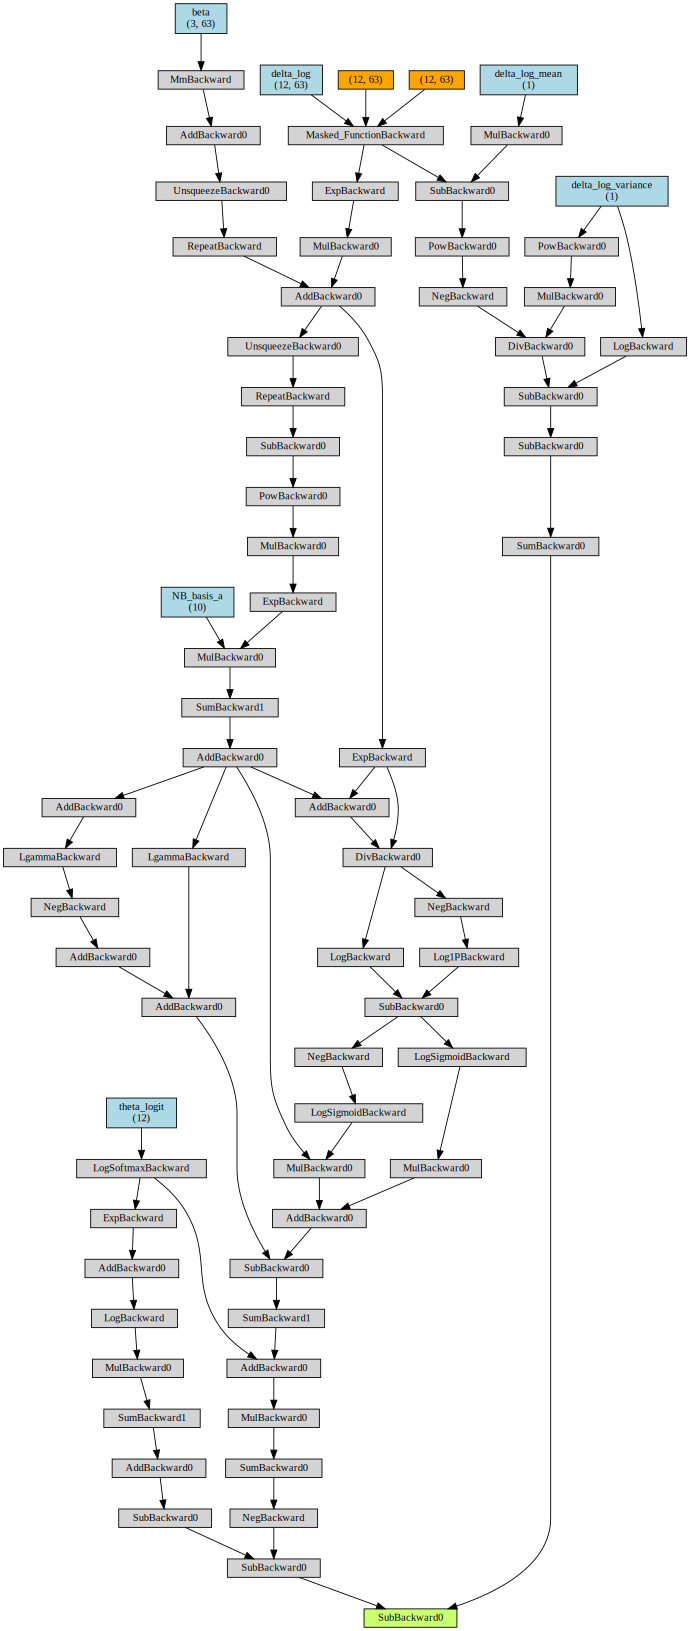

In [439]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
with torch.no_grad():
    for batch_idx,batch in enumerate(cell_dataloader):
        batch_Y=batch['Y'].to(device)
        batch_X=batch['X'].to(device)
        batch_s=batch['s'].to(device)    
    gamma_fixed,_,LL_old=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
    _,Q_old,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_fixed,mode='M')
    
print(LL_old)
print(Q_old)


from torchviz import make_dot, make_dot_from_trace

make_dot(model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_fixed,mode='M')[1],params=dict(model.named_parameters()))